## Google Merchandise Store: A Data-Driven Exploration of Online Shopping Trends

Welcome to my [**Web Analytics Project!**](https://github.com/vijaybhaskar98/Google-analytics-) In this notebook, I delve into the data from the Google Merchandise Store, aiming to unravel its patterns and gain a deeper understanding. Join me on this exploration as we navigate through the intricacies of the data.

In [6]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Import Specific libraries
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import bq_helper
from google.cloud import bigquery
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


## Estimating the query size🕵️‍

🚀 Before we delve into the project, let's keep in mind BigQuery prices. 💸 Google Cloud Platform charges based on query size, and failure to optimize it can lead to a drastic increase in project costs. Luckily, we can gauge the query size before running it. 📊 Use the following query to ensure the best optimization, especially when dealing with high-scaled data!

In [8]:
# Estimate the query size by fetching datafor the month of September 2016
query = """
    SELECT *
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE _TABLE_SUFFIX BETWEEN '20160901' AND '20160930'
    ;
"""
#Estimate the query size with dry run
dry_run_config = bigquery.QueryJobConfig(dry_run=True)
dry_run_query_job = client.query(query, job_config=dry_run_config)

print("This query will process:", dry_run_query_job.total_bytes_processed / (1024 * 1024), "MB")

This query will process: 643.6495161056519 MB


The query above has a size of 643 MB. It's advisable to regularly check the query size during processing to ensure cost-effectiveness

Google Analytics extracts data from linked websites in table format. 📊 These tables come in various types such as hourly, daily, and monthly. Google structurizes these tables after predefined intervals. Let's run a query to find out how many tables the Google Analytics sample data contains. 🔍

In [9]:
bqh = bq_helper.BigQueryHelper("bigquery-public-data", "google_analytics_sample")
table_list = bqh.list_tables()
print (f'Number of tables: {len(table_list)} +  \nFirst 3 tables: {table_list[0:3]}')

Using Kaggle's public dataset BigQuery integration.
Number of tables: 366 +  
First 3 tables: ['ga_sessions_20160801', 'ga_sessions_20160802', 'ga_sessions_20160803']


In [10]:
bqh.head("ga_sessions_20170801", num_rows=3)

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,None,1,1501591568,1501591568,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'South...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",3418334011779872055,None,None,Organic Search,Not Socially Engaged
1,None,2,1501589647,1501589647,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 5, 'minut...",2474397855041322408,None,None,Referral,Not Socially Engaged
2,None,1,1501616621,1501616621,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/analytics/web/', 'campaign'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'North...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",5870462820713110108,None,None,Referral,Not Socially Engaged


### Quarterly metrics

In [14]:
query=\
"""
select 
format("%'d",count(distinct fullVisitorId)) as users,
format("%'d",sum(totals.visits)) as visits,
format("%'d",sum(totals.pageviews)) as pageviews,
sum(totals.transactions) as transactions,
sum(totals.transactionRevenue)/1000000 as revenue_M
from `bigquery-public-data.google_analytics_sample.ga_sessions_*`
where _table_suffix between '20161001' and '20161231'
and totals.totalTransactionRevenue is not null
"""

job=client.query(query)
res=job.to_dataframe()
res.head()

,users,visits,pageviews,transactions,revenue_M
0,"2,877","3,186","93,076",3324,386900.87


In the last quarter of 2016, the store recorded 2,877 users, 3324 transactions, and generated a revenue of $386,900 (M).

### Month wise visits and revenue 

In [15]:
query = """    
    SELECT 
        DATE_TRUNC(PARSE_DATE('%Y%m%d',date), MONTH) AS month,
        SUM(totals.visits) AS visits,        
        SUM(totals.transactionRevenue)/1000000 AS revenue_M

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161231'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 1
"""

safe_query_job = client.query(query)
df1 = safe_query_job.to_dataframe()
df1.head()

,month,visits,revenue_M
0,2016-10-01,872,113329.07
1,2016-11-01,919,119013.87
2,2016-12-01,1395,154557.93


In the above query, the last quarter, December, experienced approximately a 20% higher number of visits and transactions compared to the average. 📈 This surge can be attributed to the festive season, particularly Christmas celebrations. 🎄✨

### Revenue by country🌍💰

In [16]:
# Quarterly revenue by country
query = """
    SELECT 
        geoNetwork.country AS country,   
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 2 desc
    
"""
safe_query_job = client.query(query)
df2 = safe_query_job.to_dataframe()
df2.head()

,country,revenue
0,United States,365518.96
1,Canada,9975.27
2,Kenya,3679.30
3,Puerto Rico,656.16
4,United Kingdom,527.10


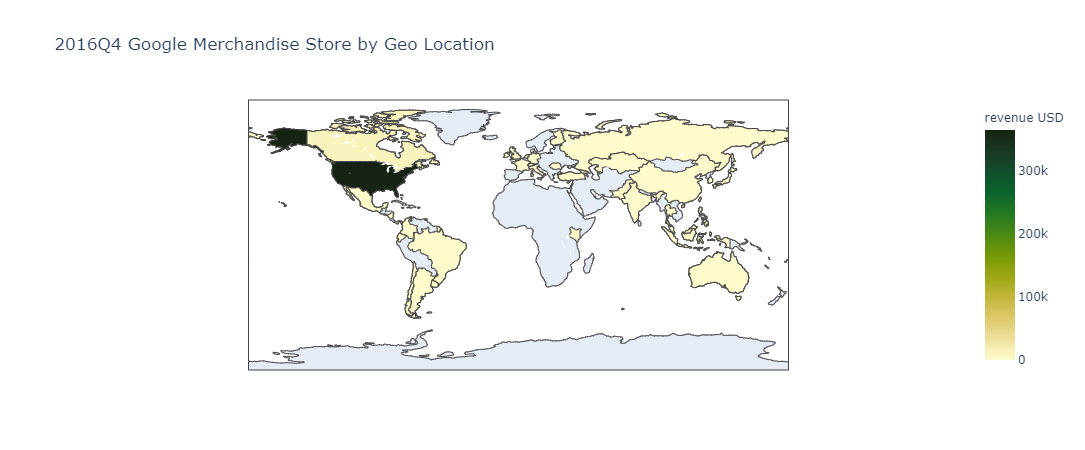

In [17]:
# create a heatmap of revenue by geo location

fig = go.Figure(data=go.Choropleth(
    locations=df2['country'], 
    z = df2['revenue'].astype(float),
    locationmode = 'country names', 
    colorscale = 'speed',
    colorbar_title = "revenue USD",
))

fig.update_layout(
    title_text = '2016Q4 Google Merchandise Store by Geo Location',)
fig.show()

## Top Channels sending Traffic

In [18]:
query = """
    SELECT
        channelGrouping as channel,
        SUM(totals.totalTransactionRevenue)/1000000 AS revenue,
        SUM(totals.transactions) AS transactions,
        COUNT(DISTINCT fullVisitorId) AS users,
        SUM(totals.visits) AS sessions,
        SUM(totals.pageviews) AS pageviews
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY
        1
    ORDER BY
        2 DESC
"""
safe_query_job = client.query(query)
df3 = safe_query_job.to_dataframe()
df3.head()

,channel,revenue,transactions,users,sessions,pageviews
0,Referral,182578.60,1540,1331,1470,42829
1,Direct,128141.06,568,456,539,16132
2,Organic Search,93376.88,991,905,956,28247
3,Paid Search,14028.37,164,153,160,4277
4,Display,4728.45,34,34,34,1044


Text(0.5, 1.0, 'Total Pageviews by Channel')

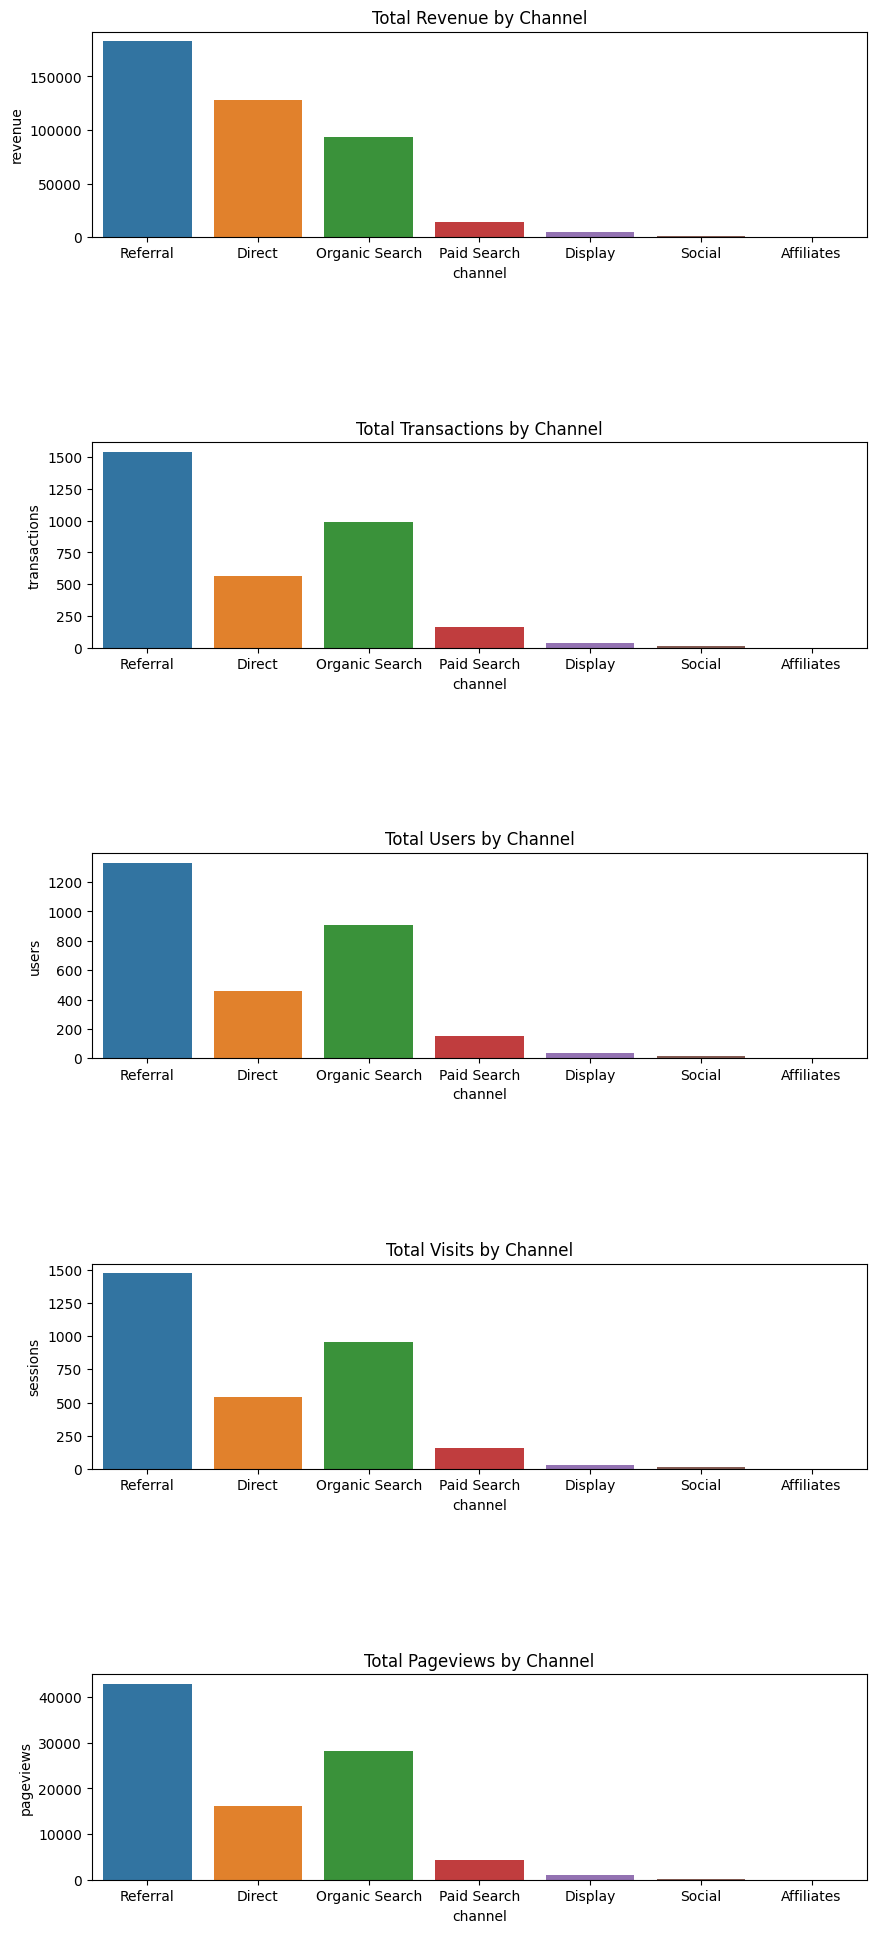

In [19]:
# set up the matplotlib figure
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(10,24))
fig.subplots_adjust(hspace=1)

sns.barplot(x='channel',y='revenue',data=df3,ax=ax1)

sns.barplot(x='channel',y='transactions',data=df3,ax=ax2)

sns.barplot(x='channel',y='users',data=df3,ax=ax3)

sns.barplot(x='channel',y='sessions',data=df3,ax=ax4)

sns.barplot(x='channel',y='pageviews',data=df3,ax=ax5)

ax1.set_title('Total Revenue by Channel')
ax2.set_title('Total Transactions by Channel')
ax3.set_title('Total Users by Channel')
ax4.set_title('Total Visits by Channel')
ax5.set_title('Total Pageviews by Channel')


## User Behavior On Google Merchandise📊👥

In [20]:
query = """
    SELECT 
        fullVisitorId AS userID,
        AVG(totals.timeOnSite) As avgTimeOnSite,
        SUM(totals.pageviews) AS pageviews,
        SUM(totals.transactions) AS transactions
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY
        1
    ORDER BY 1
        
"""
safe_query_job = client.query(query)
df4 = safe_query_job.to_dataframe()

df4['transactions'].fillna(0, inplace=True)
df4.head()

,userID,avgTimeOnSite,pageviews,transactions
0,0000010278554503158,194.0,8.0,0.0
1,0000020424342248747,297.0,13.0,0.0
2,0000152474579038632,162.0,2.0,0.0
3,0000174067426171406,559.5,30.0,0.0
4,000033471059618621,NaN,1.0,0.0


In [21]:
# Finding the relation throuh pearson co realtion
pearson_corr = df4.corr(method='pearson')
pearson_corr

,userID,avgTimeOnSite,pageviews,transactions
userID,1.000000,-0.007035,-0.002393,-0.000514
avgTimeOnSite,-0.007035,1.000000,0.454428,0.242365
pageviews,-0.002393,0.454428,1.000000,0.525083
transactions,-0.000514,0.242365,0.525083,1.000000


<Axes: >

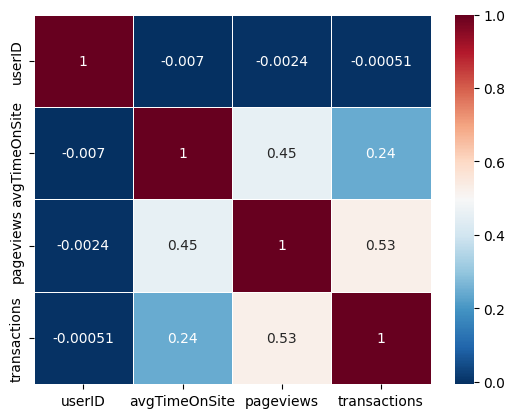

In [22]:
sns.heatmap(pearson_corr,xticklabels=pearson_corr.columns,
              yticklabels=pearson_corr.columns,cmap='RdBu_r',
              annot=True,linewidth=0.5)

## Most visited pages on site ?

In [23]:
query = """
    SELECT
        hits.page.pagePathLevel1 AS pagePath,
        SUM(totals.pageviews) AS pageviews
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
"""
safe_query_job = client.query(query)
df5 = safe_query_job.to_dataframe()
df5

,pagePath,pageviews
0,/google+redesign/,13059899
1,/home,2320076
2,/basket.html,2251571
3,/store.html,693064
4,/signin.html,373752
5,/asearch.html,342792
6,/yourinfo.html,309919
7,/payment.html,305266
8,/ordercompleted.html,214672
9,/revieworder.html,144310


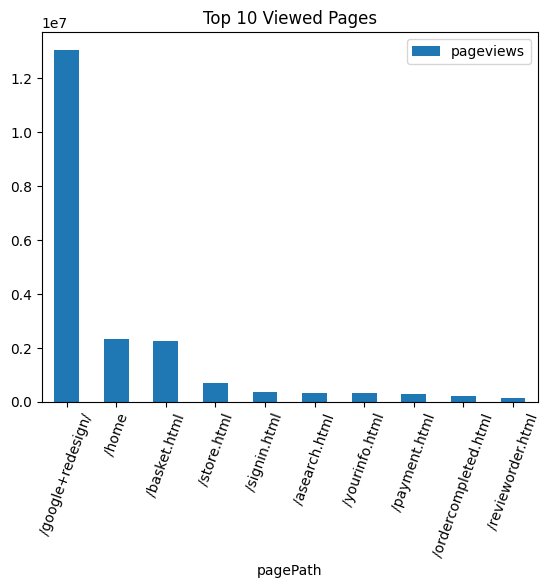

In [24]:
df5.plot.bar(x='pagePath', y='pageviews', rot=70, title='Top 10 Viewed Pages')
plt.show()

## Products analytics📈🛍️ 

In [25]:
query = """
    SELECT
        product.v2ProductCategory AS product_category,
        product.v2ProductName AS product_name,
        product.productSKU AS product_sku,
        product.productPrice/1e6 AS product_price,
        product.productQuantity AS product_quantity,
        product.productRevenue/1e6 AS product_revenue,
        totals.totalTransactionRevenue/1e6 AS total_revenue
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND productRevenue IS NOT NULL
"""
safe_query_job = client.query(query)
df6 = safe_query_job.to_dataframe()
df6.head()

,product_category,product_name,product_sku,product_price,product_quantity,product_revenue,total_revenue
0,Electronics,Recycled Mouse Pad,GGOEGODR017799,1.20,10,14.00,14.00
1,Apparel,YouTube Onesie Heather,GGOEYAWJ061453,19.19,1,25.19,25.19
2,Office,Google Metallic Notebook Set,GGOEGOLC014299,4.79,50,240.50,240.50
3,Apparel,Google Onesie Green,GGOEGAWH061348,19.19,1,25.19,25.19
4,Apparel,Google Women's Convertible Vest-Jacket Sea Foa...,GGOEGATH060714,98.99,1,105.99,105.99


<Axes: xlabel='product_category'>

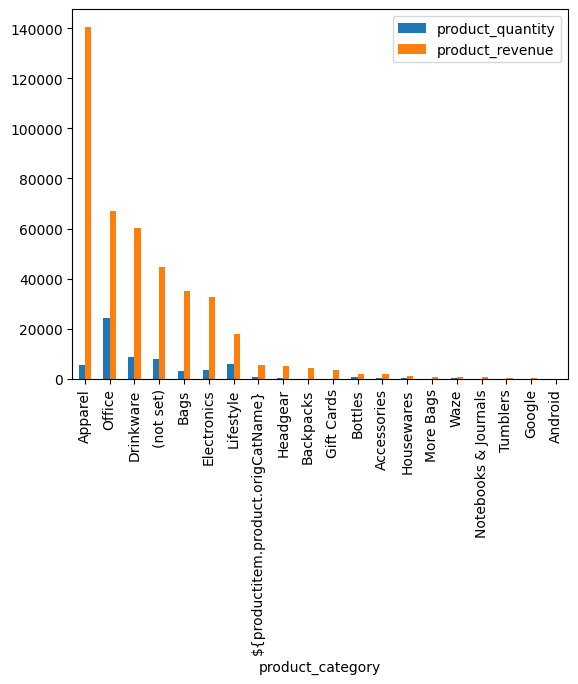

In [26]:
pivot = pd.pivot_table(df6, index=['product_category'], values=['product_revenue', 'product_quantity'], aggfunc=np.sum).sort_values(by='product_revenue', ascending=False)
pivot.plot(kind='bar')

## Visits from continent🌍👀

In [29]:
query = """
    SELECT geoNetwork AS place
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
"""

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
q_job = client.query(query, job_config=safe_config)

df8 = q_job.to_dataframe()

continent_lst = []
for x in df8['place']:
    x = x['continent']
    continent_lst.append(x)
df8['continents'] = continent_lst

continent_count = {'Americas': 0, 'Asia': 0, 'Europe': 0, 'Oceania': 0, 'Africa': 0}
for continent in df8['continents']:
    if continent == 'Americas':
        continent_count['Americas'] += 1
    if continent == 'Asia':
        continent_count['Asia'] += 1
    if continent == 'Europe':
        continent_count['Europe'] += 1
    if continent == 'Oceania':
        continent_count['Oceania'] += 1
    if continent == 'Africa':
        continent_count['Africa'] += 1

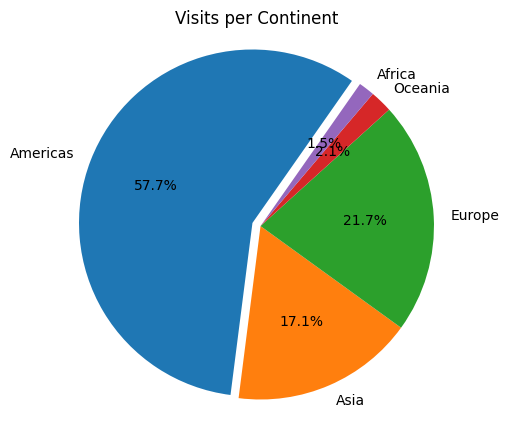

In [30]:
labels = continent_count.keys()
data = continent_count.values()
explode = (0.05, 0, 0,0,0)

plt.figure(figsize=(5,5))
plt.pie(data, labels=labels, explode=explode, autopct='%1.1f%%', startangle=55)
plt.title('Visits per Continent')
plt.axis('equal') 

plt.show()

## Time based analytics⏰📊

In [31]:
from time import time

def show_amount_of_data_scanned(query):
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))


In [32]:
query = """
     SELECT date, august.device.deviceCategory AS device, SUM(august.totals.visits) AS visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801` AS august
     GROUP BY date, device
     UNION ALL
     SELECT date, july.device.deviceCategory as device, SUM(july.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170701` as july
     GROUP BY date, device
     UNION ALL
     SELECT date, june.device.deviceCategory as device, SUM(june.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170601` as june
     GROUP BY date, device
     UNION ALL
     SELECT date, may.device.deviceCategory as device, SUM(may.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170501` as may
     GROUP BY date, device
     UNION ALL
     SELECT date, april.device.deviceCategory as device, SUM(april.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170401` as april
     GROUP BY date, device
     ORDER BY date, device
     """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

df9 = query_job.to_dataframe()

print(df9)

show_amount_of_data_scanned(query)
show_time_to_run(query)

        date   device  visits
0   20170401  desktop    1420
1   20170401   mobile     646
2   20170401   tablet     104
3   20170501  desktop    1706
4   20170501   mobile     770
5   20170501   tablet     112
6   20170601  desktop    1972
7   20170601   mobile     758
8   20170601   tablet      96
9   20170701  desktop     869
10  20170701   mobile    1036
11  20170701   tablet     143
12  20170801  desktop    1742
13  20170801   mobile     725
14  20170801   tablet      89
Data processed: 0.0 GB
Time to run: 1.419 seconds


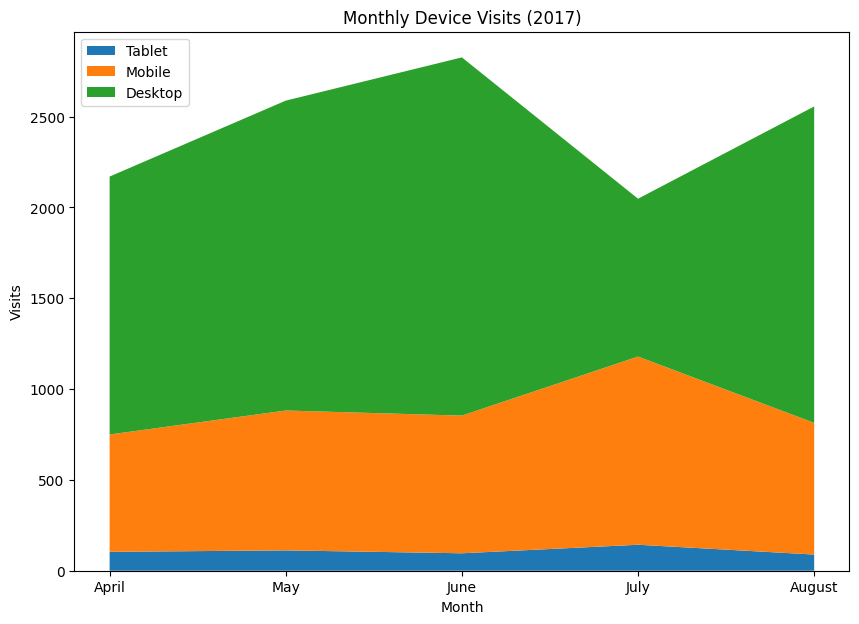

In [33]:
desktop = df9['visits'][0::3]
mobile = df9['visits'][1::3]
tablet = df9['visits'][2::3]

x = ['April', 'May', 'June', 'July', 'August']

y = np.vstack([tablet, mobile, desktop])

labels = ['Tablet', 'Mobile', 'Desktop']

plt.figure(figsize=(10,7))
plt.stackplot(x, tablet, mobile, desktop, labels=labels)
plt.title('Monthly Device Visits (2017)')
plt.ylabel('Visits')
plt.xlabel('Month')
plt.legend(loc='upper left')
plt.show()

**Conclusion:**
In this project, we delved into important metrics—such as visits, users, transactions, and revenue—analyzing them on a monthly and quarterly basis. The exploration revealed distinct trends and patterns, particularly in a seasonal context. We navigated through insights on the most visited pages, geographical revenue generation, and timely metrics visualization. 📈🌐⏰

Thank you for visiting the notebook! 🙏